In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [45]:
train_data=datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


In [46]:
image,label=train_data[0]
image.shape

torch.Size([1, 28, 28])

In [47]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [48]:
class_names=train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

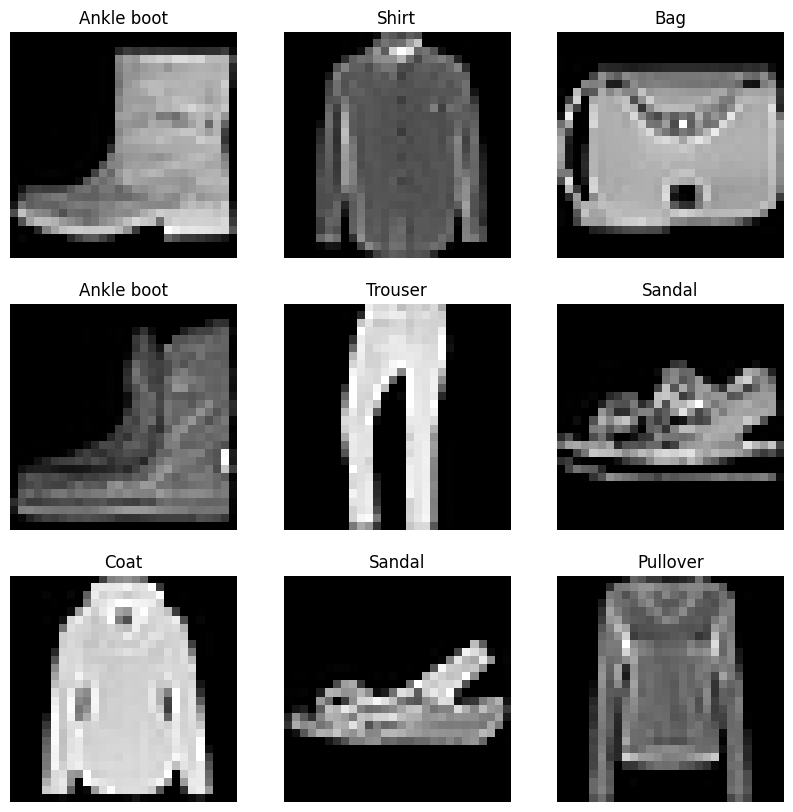

In [49]:
torch.manual_seed(42)

fig=plt.figure(figsize=(10,10))

for i in range(1,10):
  randindx=torch.randint(0,len(train_data),size=[1]).item()
  img,label=train_data[randindx]
  fig.add_subplot(3,3,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)



In [50]:
from torch.utils.data import DataLoader

batchsize=32


train_dataloader=DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=batchsize,shuffle=False)


In [51]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [52]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [53]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [54]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [55]:
class FashionMNISTModelv1(nn.Module):
  def __init__(self,input_shape:int,hidden_units1:int,hidden_units2:int,output_shape:int):
    super().__init__()
    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units1),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units1,out_features=hidden_units2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units2,out_features=output_shape),
        nn.ReLU()


    )

  def forward(self,x:torch.tensor):
    return self.layer_stack(x)



In [56]:
torch.manual_seed(42)
from helper_functions import accuracy_fn

model_1=FashionMNISTModelv1(input_shape=784,hidden_units1=50,hidden_units2=20,output_shape=len(class_names)).to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),lr=1e-3)

next(model_1.parameters()).device

device(type='cpu')

In [57]:
def train_step(model:nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  model.train()
  model.to(device)
  train_loss,train_acc=0,0

  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)
    y_pred=model(X)

    loss=loss_fn(y_pred,y)
    train_loss+=loss
    train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  print(f"Train loss: {train_loss} | Train accuracy: {train_acc}%")


def test_step(model:nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:nn.Module,accuracy_fn,device:torch.device=device):
  test_loss,test_acc=0,0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for X,y in dataloader:
      X,y=X.to(device),y.to(device)
      test_pred=model(X)
      test_loss+=loss_fn(test_pred,y)
      test_acc+= accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))

    test_loss/=len(dataloader)
    test_acc/=len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



In [58]:
torch.manual_seed(42)

from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 20

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(dataloader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(dataloader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.9807069301605225 | Train accuracy: 69.005%
Test loss: 0.87800 | Test accuracy: 71.51%

Epoch: 1
---------
Train loss: 0.8385924100875854 | Train accuracy: 72.40166666666667%
Test loss: 0.84252 | Test accuracy: 72.15%

Epoch: 2
---------
Train loss: 0.8080899715423584 | Train accuracy: 73.13333333333334%
Test loss: 0.83849 | Test accuracy: 72.21%

Epoch: 3
---------
Train loss: 0.7869904041290283 | Train accuracy: 73.48%
Test loss: 0.81254 | Test accuracy: 72.57%

Epoch: 4
---------
Train loss: 0.7740881443023682 | Train accuracy: 73.65%
Test loss: 0.79796 | Test accuracy: 73.11%

Epoch: 5
---------
Train loss: 0.7614609003067017 | Train accuracy: 73.96666666666667%
Test loss: 0.79473 | Test accuracy: 73.17%

Epoch: 6
---------
Train loss: 0.75238436460495 | Train accuracy: 74.10166666666667%
Test loss: 0.78781 | Test accuracy: 73.06%

Epoch: 7
---------
Train loss: 0.7413768172264099 | Train accuracy: 74.34833333333333%
Test loss: 0.79548 | Test accurac

In [59]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
)
model_1_results

{'model_name': 'FashionMNISTModelv1',
 'model_loss': 0.8228625059127808,
 'model_acc': 72.10463258785943}

In [65]:
class FashionMNISTModelv2(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)# It's because each layer of our network compresses and changes the shape of our inputs data
    )

  def forward(self,x:torch.tensor):
    x=self.block1(x)
    x=self.block2(x)
    x=self.classifier(x)
    return x


In [66]:
torch.manual_seed(42)
model_2 = FashionMNISTModelv2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelv2(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [67]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.1)

In [68]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epoch=20

for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}---\n")
  train_step(
      dataloader=train_dataloader,
      model=model_2,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device
  )
  test_step(
      dataloader=test_dataloader,
      model=model_2,
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn,
      device=device
  )


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:0---

Train loss: 0.5951793193817139 | Train accuracy: 78.375%
Test loss: 0.39500 | Test accuracy: 85.99%

Epoch:1---

Train loss: 0.3653560280799866 | Train accuracy: 86.90166666666667%
Test loss: 0.35244 | Test accuracy: 86.91%

Epoch:2---

Train loss: 0.3258754312992096 | Train accuracy: 88.12833333333333%
Test loss: 0.32719 | Test accuracy: 88.07%

Epoch:3---

Train loss: 0.30489426851272583 | Train accuracy: 88.91666666666667%
Test loss: 0.32312 | Test accuracy: 88.25%

Epoch:4---

Train loss: 0.28980833292007446 | Train accuracy: 89.56333333333333%
Test loss: 0.30836 | Test accuracy: 88.91%

Epoch:5---

Train loss: 0.2794366180896759 | Train accuracy: 89.81666666666666%
Test loss: 0.29993 | Test accuracy: 89.37%

Epoch:6---

Train loss: 0.2702654302120209 | Train accuracy: 90.08666666666667%
Test loss: 0.31035 | Test accuracy: 88.80%

Epoch:7---

Train loss: 0.26669782400131226 | Train accuracy: 90.215%
Test loss: 0.30217 | Test accuracy: 88.95%

Epoch:8---

Train loss: 0.2